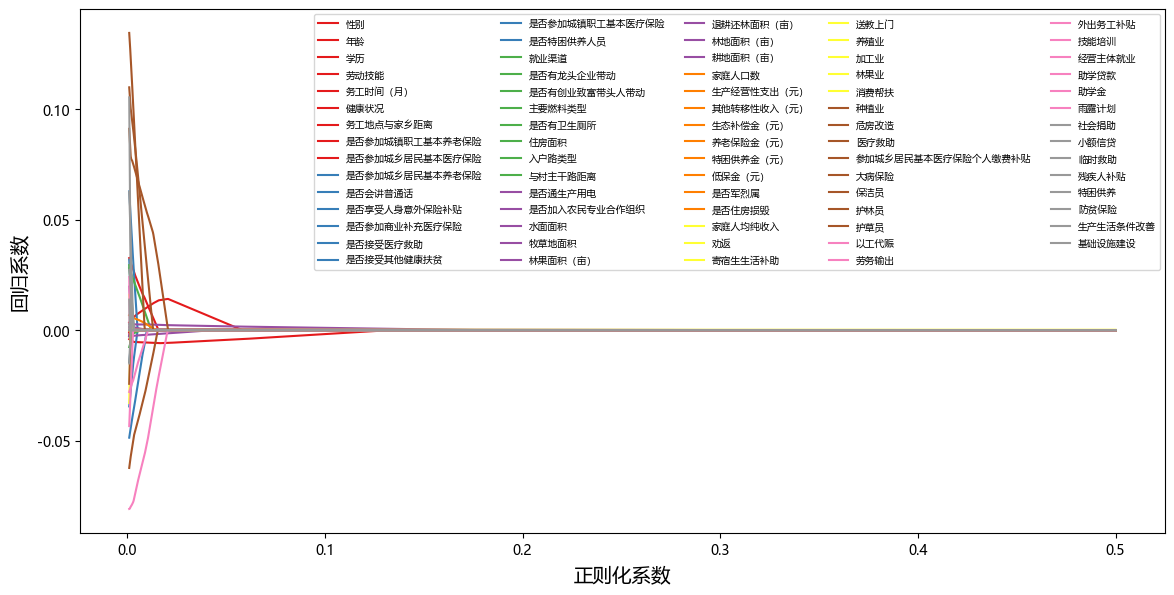

0.0057428714357178594
原始数据的方差膨胀因子:

                    特征      方差膨胀因子
0                   性别   11.046662
1                   年龄   18.997633
2                   学历    3.547266
3                 劳动技能   10.991928
4              务工时间（月）    3.978623
5                 健康状况    3.020720
6            务工地点与家乡距离    1.471097
7       是否参加城镇职工基本养老保险    1.194105
8       是否参加城乡居民基本医疗保险  372.672048
9       是否参加城乡居民基本养老保险   24.614861
10             是否会讲普通话    2.604804
11        是否享受人身意外保险补贴    4.492115
12        是否参加商业补充医疗保险    1.168346
13            是否接受医疗救助    1.111377
14          是否接受其他健康扶贫    8.034796
15      是否参加城镇职工基本医疗保险    1.007785
16            是否特困供养人员    1.347498
17                就业渠道    3.478144
18           是否有龙头企业带动   10.280284
19        是否有创业致富带头人带动    1.079746
20              主要燃料类型    6.158579
21             是否有卫生厕所  232.730495
22                住房面积   13.856258
23               入户路类型    6.662883
24             与村主干路距离    1.626484
25             是否通生产用电    2.688535
26        是否加入农民专业合

'保存结果'

In [3]:
import pandas as pd

pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['Microsoft YaHei']
rcParams['axes.unicode_minus'] = False
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso

# 忽略特定类型的警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

'''加载数据集'''
train = pd.read_excel(r'D:\2024统计建模\美姑县_喜德县_训练集.xlsx')
test_meigu = pd.read_excel(r'D:\2024统计建模\美姑县_测试集.xlsx')
test_xide = pd.read_excel(r'D:\2024统计建模\喜德县_测试集.xlsx')
input_data = pd.read_excel(r'D:\2024统计建模\编码_总数据集.xlsx')
input_train, input_test = train_test_split(input_data, test_size=0.2, random_state=42)
interation = 2000  # 迭代次数

'''检查缺失值'''
# columns_x_train = x_train.columns[x_train.isnull().any()].tolist()
# print("x_train有缺失值的列:", columns_x_train)
# columns_x_test_yanyuan = x_test_yanyuan.columns[x_test_yanyuan.isnull().any()].tolist()
# print("x_test_yanyuan有缺失值的列:", columns_x_test_yanyuan)
# columns_x_test_bushi = x_test_bushi.columns[x_test_bushi.isnull().any()].tolist()
# print("x_test_bushi有缺失值的列:", columns_x_test_bushi)
# columns_x_test_puge = x_test_puge.columns[x_test_puge.isnull().any()].tolist()
# print("x_test_puge有缺失值的列:", columns_x_test_puge)


'''
之前的想法错了，因为我们只有一个数据集，只是人为地根据县去划分三个测试集。
所以应该是输入全部的数据集，进行特征筛选和建立模型，最后用同一个模型分别对三个数据集进行测试。
'''

'''绘制岭迹图'''
from sklearn.metrics import mean_squared_error


# 定义LASSO回归函数
def lasso_regression(train, test, alpha):
    lassoreg = Lasso(alpha=alpha, max_iter=interation, fit_intercept=True)
    lassoreg.fit(train.drop(columns=['风险是否已消除']), train['风险是否已消除'])
    feature_count = np.sum(lassoreg.coef_ != 0)  # 计算该alpha下筛选出的特征数量
    y_pred = lassoreg.predict(test.drop(columns=['风险是否已消除']))
    mse = mean_squared_error(test['风险是否已消除'], y_pred)
    ret = [alpha, mse]
    ret.append(feature_count)  # 非零系数的数量
    ret.extend(lassoreg.coef_)
    return ret


# 记录不同alpha下的准确率以及各特征的回归系数
alpha_lasso = np.linspace(0.001, 0.5, interation)
# 定义coef_matrix_lasso每列的标签，分别为alpha、mse以及数据集的各特征名称
col = ["alpha", "mse", "feature_count"] + list(input_train.iloc[:, 4:-1])
# 将采样的alpha数值插入到占位符上
ind = ["alpha_%.4g" % alpha_lasso[i] for i in range(0, len(alpha_lasso))]
# 存储Lasso回归不同alpha值下的准确率和系数的DataFrame
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

# 调用函数，将函数返回的结果录入
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i] = lasso_regression(input_train.iloc[:, 4:], input_test.iloc[:, 4:], alpha_lasso[i])
coef_matrix_lasso.to_excel(r'LASSO系数矩阵.xlsx', index=True)

# 绘图
plt.figure(figsize=(14, 6.8))
for i in np.arange(len(list(input_train.iloc[:, 4:-1]))):
    plt.plot(coef_matrix_lasso["alpha"],
             coef_matrix_lasso[list(input_train.iloc[:, 4:-1])[i]],
             color=plt.cm.Set1(i / len(list(input_train.iloc[:, 4:-1]))),
             label=list(input_train.iloc[:, 4:-1])[i])
    plt.legend(loc="upper right", ncol=5, prop={'size': 7})
    plt.xlabel("正则化系数", fontsize=14)
    plt.ylabel("回归系数", fontsize=14)
    # plt.ylim([-0.004, 0.01])
    # plt.title('盐源县_LASSO回归岭迹图', fontsize=16)
plt.savefig(r'LASSO回归岭迹图', dpi=600)
plt.show()

'''十折交叉验证选择最佳正则化系'''
from sklearn.linear_model import LassoCV

alpha_choose = np.linspace(0.001, 0.5, interation)

lasso_cv = LassoCV(alphas=alpha_choose, cv=10, max_iter=interation)
lasso_cv.fit(input_data.iloc[:, 4:-1], input_data.iloc[:, -1])
# 输出最佳的alpha值
lasso_best_alpha = lasso_cv.alpha_
print(lasso_best_alpha)

'''特征筛选'''
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(df):
    vif = pd.DataFrame()
    vif['特征'] = df.columns
    vif['方差膨胀因子'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    # 调用 statsmodels.stats.outliers_influence.variance_inflation_factor 函数计算第 i 列自变量的方差膨胀因子
    return vif


'''建立Lasso回归模型'''
lasso_model = Lasso(alpha=lasso_best_alpha, fit_intercept=True,
                    precompute=False, copy_X=False,
                    max_iter=interation, tol=0.0001, warm_start=False,
                    positive=False, random_state=1412, selection='cyclic')

'''
alpha： 正则化强度，控制稀疏性
fit_intercept： 拟合截距
precompute： 是否预计算 Gram 矩阵，通常设置为 False
copy_X： 对输入数据进行复制
max_iter： 最大迭代次数，控制算法运行的最大迭代次数
tol=0.0001： 收敛的容忍度，指定算法收敛的阈值
warm_start： 如果为 True，则使用前一个调用的解决方案以适应的权重
positive： 如果为 True，则要求系数为正
selection： 指定系数更新的策略。'cyclic' 表示按循环顺序逐个更新系数
'''
lasso_model.fit(input_data.iloc[:, 4:-1], input_data.iloc[:, -1])
selected_features = input_data.iloc[:, 4:-1].columns[lasso_model.coef_ != 0]

'''计算Lasso前的VIF'''
vif_before = pd.DataFrame()
vif_before["特征"] = input_data.iloc[:, 4:-1].columns
vif_before["方差膨胀因子"] = [variance_inflation_factor(input_data.iloc[:, 4:-1].values, i) for i
                              in range(input_data.iloc[:, 4:-1].shape[1])]
print("原始数据的方差膨胀因子:\n")
print(vif_before)

'''计算筛选特征后的VIF'''
input_data_selected = input_data.iloc[:, 4:-1][selected_features]
vif_after = pd.DataFrame()
vif_after["特征"] = selected_features
vif_after["方差膨胀因子"] = [variance_inflation_factor(input_data_selected.values, i) for i in
                             range(input_data_selected.shape[1])]
print("筛选特征后的方差膨胀因子:\n")
print(vif_after)

'''保存结果'''
vif_before.to_excel(r'初始方差膨胀因子.xlsx', index=False)
vif_after.to_excel(r'LASSO后方差膨胀因子.xlsx', index=False)

train_selected = train[['县', '姓名', '与户主关系', '户编号'] + selected_features.tolist() + ['风险是否已消除']]  # 训练集
train_selected.to_excel(r'训练集_LASSO.xlsx', index=False)

test_meigu_selected = test_meigu[
    ['县', '姓名', '与户主关系', '户编号'] + selected_features.tolist() + ['风险是否已消除']]
test_meigu_selected.to_excel(r'美姑县_LASSO.xlsx', index=False)

test_xide_selected = test_xide[
    ['县', '姓名', '与户主关系', '户编号'] + selected_features.tolist() + ['风险是否已消除']]
test_xide_selected.to_excel(r'喜德县_LASSO.xlsx', index=False)

In [4]:
lasso_best_alpha

0.0057428714357178594